In [1]:
# Standard libraries
import numpy as np

# Scikit-learn libraries
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Imbalanced-learn library
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Category encoders
from category_encoders import TargetEncoder

# Custom tools and transformers
from tools.DataLoader import DataLoader
from tools.EDA import EDA
from tools.SLModelEvaluator import SLModelEvaluator
from tools.SLModelTrainer import SLModelTrainer
from transformers.DropHighNaNColumnsTransformer import DropHighNaNColumnsTransformer

# Other classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
# Step 1: Load Data using DataLoader
data_loader = DataLoader(request_type="local", path="db/final_proj_data.csv")
df = data_loader.load_data()

In [3]:
data_loader_valid = DataLoader(request_type="local", path="db/final_proj_test.csv")
df_valid = data_loader_valid.load_data()

In [4]:
# Step 2: Perform EDA using the EDA class
eda = EDA(df)
eda.perform_full_eda()

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


None

,Column,Has_Nulls,Dtype
Var1,Var1,True,float64
Var2,Var2,True,float64
Var3,Var3,True,float64
Var4,Var4,True,float64
Var5,Var5,True,float64
...,...,...,...
Var227,Var227,False,object
Var228,Var228,False,object
Var229,Var229,True,object
Var230,Var230,True,float64



Dataset Shape:

(10000, 231)

Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max
Var1,133.0,14.977444,66.456008,0.0,0.000,0.00,16.000,680.0
Var2,266.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
Var3,266.0,341.052632,2810.606975,0.0,0.000,0.00,0.000,42588.0
Var4,280.0,0.096429,0.928243,0.0,0.000,0.00,0.000,9.0
Var5,241.0,233810.124481,553230.515446,0.0,0.000,0.00,117235.000,3024000.0
...,...,...,...,...,...,...,...,...
Var189,4206.0,272.455064,86.752531,6.0,204.000,270.00,330.000,642.0
Var190,43.0,25725.112326,37487.484852,0.0,1312.875,10853.82,37491.525,191167.2
Var209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var230,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing Values:



Var1       9867
Var2       9734
Var3       9734
Var4       9720
Var5       9759
          ...  
Var227        0
Var228        0
Var229     5561
Var230    10000
y             0
Length: 231, dtype: int64


Sample Data:



,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,...,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,...,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,...,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [5]:
eda.missing_values_percentage(target="y")

Percentage of Missing Values in Each Column:


,Column,Missing Percentage
229,Var230,100.0
174,Var175,100.0
54,Var55,100.0
38,Var39,100.0
140,Var141,100.0
...,...,...
201,Var202,0.0
198,Var199,0.0
197,Var198,0.0
195,Var196,0.0



Summary of Missing Values:


,Average Missing Percentage,Median Missing Percentage,Maximum Missing Percentage,Minimum Missing Percentage,Standard Deviation of Missing Percentage,First Quartile (Q1) of Missing Percentage,Third Quartile (Q3) of Missing Percentage,Interquartile Range (IQR) of Missing Percentage
0,69.715174,97.34,100.0,0.0,41.833357,10.2,98.67,88.47


In [6]:
evaluator = SLModelEvaluator()

In [7]:
X = df.drop(columns=["y"])
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# Define categorical transformer for GradientBoosting
cat_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder()),
    ]
)

# Define numerical transformer for GradientBoosting
num_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
)

# Define preprocessor for GradientBoosting
preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", num_transformer_gb, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer_gb,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [10]:
X_train_F = DropHighNaNColumnsTransformer(threshold=0.8).fit_transform(X_train)
X_train_T = preprocessor_gb.fit_transform(X_train_F, y_train)

# X_F = DropHighNaNColumnsTransformer(threshold=0.8).fit_transform(X)
# X_T = preprocessor_gb.fit_transform(X_F, y)

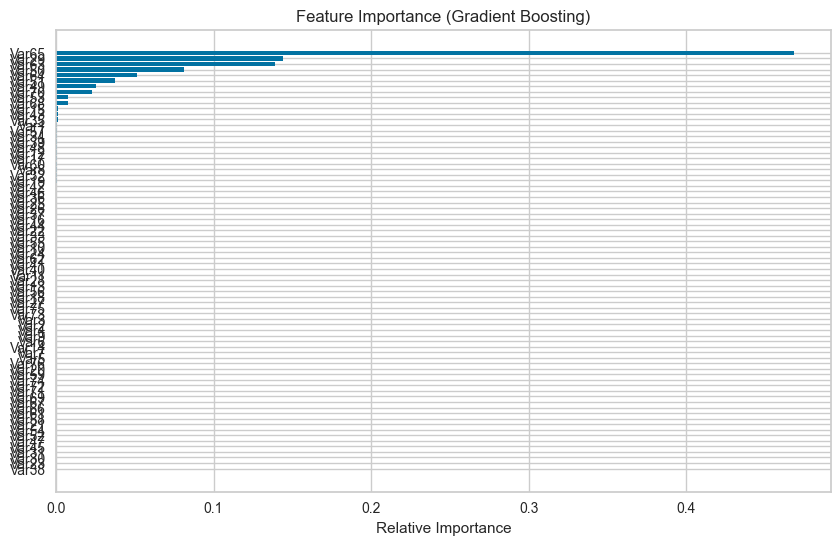

,Feature,Importance
8,Var53,0.007640
9,Var68,0.007442
10,Var15,0.001486
11,Var43,0.001263
12,Var35,0.001092
...,...,...
71,Var45,0.000000
72,Var31,0.000000
73,Var30,0.000000
74,Var23,0.000000



Summary Statistics for Low Importance Features:


,mean,median,min,max,sum
Importance,0.000437,0.000104,0.0,0.00764,0.0297


In [11]:
low_importance_features = evaluator.feature_importance(
    X_train_T,
    y_train,
    df,
    print_zero_importance=True,
    importance_threshold=0.01,
    model_type="gradient_boosting",
)

# low_importance_features = evaluator.feature_importance(
#     X_T,
#     y,
#     df,
#     print_zero_importance=True,
#     importance_threshold=0.01,
#     model_type="gradient_boosting",
# )

In [12]:
# Full preprocessing pipeline for HistGradientBoosting without nested Pipelines

full_pipeline_hist_gradient_boosting = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb)
        ("power", PowerTransformer()),
        ("adasyn", ADASYN(random_state=42)),
        ("model", HistGradientBoostingClassifier(random_state=42)),
    ]
)

<>:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_2566352/588888754.py:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ("preprocessing", preprocessor_gb)


TypeError: 'tuple' object is not callable

In [ ]:
# SVM Pipeline
full_pipeline_svm = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb),
        ("power", PowerTransformer()),
        ("adasyn", ADASYN(random_state=42)),
        ("model", SVC(random_state=42)),
    ]
)

# XGBoost Pipeline
full_pipeline_xgboost = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb),
        ("power", PowerTransformer()),
        ("adasyn", ADASYN(random_state=42)),
        (
            "model",
            XGBClassifier(
                use_label_encoder=False, eval_metric="logloss", random_state=42
            ),
        ),
    ]
)

# LightGBM Pipeline
full_pipeline_lightgbm = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb),
        ("adasyn", ADASYN(random_state=42)),
        ("model", LGBMClassifier(random_state=42)),
    ]
)

# CatBoost Pipeline
full_pipeline_catboost = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb),
        ("power", PowerTransformer()),
        ("adasyn", ADASYN(random_state=42)),
        ("model", CatBoostClassifier(silent=True, random_state=42)),
    ]
)

# Logistic Regression Pipeline
full_pipeline_logreg = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer()),
        ("preprocessing", preprocessor_gb),
        ("adasyn", ADASYN(random_state=42)),
        ("model", LogisticRegression(random_state=42)),
    ]
)

In [ ]:
# Define the parameter grid for RandomForest
param_grids = {
    "hist_gradient_boosting": {
        "drop_high_nan__threshold": [0.8],
        "adasyn__n_neighbors": [5, 7, 10],
        "model__learning_rate": [0.1],
        "model__max_iter": [100],
        "model__max_leaf_nodes": [31],
        "model__max_depth": [5],
        "model__min_samples_leaf": [40],
        "model__l2_regularization": [0.3],
    },
    "xgboost": {
        "drop_high_nan__threshold": [0.8],
        "adasyn__n_neighbors": [5, 7, 10],
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
        "model__max_depth": [3],
        "model__subsample": [0.8],
        "model__colsample_bytree": [0.8],
    },
    "lightgbm": {
        "drop_high_nan__threshold": [0.8],
        "adasyn__n_neighbors": [5, 7, 10],
        "model__n_estimators": [100],
        "model__learning_rate": [0.1],
        "model__max_depth": [5, -1],
        "model__num_leaves": [31],
        "model__subsample": [0.8],
        "model__colsample_bytree": [0.8],
        "model__reg_alpha": [0, 0.1],
        "model__reg_lambda": [0.5, 1.0],
    },
    "catboost": {
        "drop_high_nan__threshold": [0.8],
        "adasyn__n_neighbors": [5, 7, 10],
        "model__iterations": [100, 200],
        "model__learning_rate": [0.1],
        "model__depth": [5],
        "model__l2_leaf_reg": [3],
        "model__border_count": [32, 64],
    },
    "logreg": {
        "drop_high_nan__threshold": [0.8],
        "adasyn__n_neighbors": [5, 7, 10],
        "model__C": [1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["liblinear"],
    },
}

In [ ]:
# Combine pipelines into a dictionary
model_pipelines = {
    "hist_gradient_boosting": full_pipeline_hist_gradient_boosting,
    "xgboost": full_pipeline_xgboost,
    "lightgbm": full_pipeline_lightgbm,
    "catboost": full_pipeline_catboost,
    "logreg": full_pipeline_logreg,
}

In [ ]:
model_trainer = SLModelTrainer()

model_trainer.train(
    X_train,
    y_train,
    model_pipelines,
    param_grids,
    scoring="balanced_accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
)
# model_trainer.train(
#     X, y, model_pipelines, param_grids, scoring="balanced_accuracy", cv=5, verbose=1
# )

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype,

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nord/.local/lib/python3.12/site-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype,

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/nord/.local/lib/python3.12/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/usr/lib/python3/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  

[LightGBM] [Info] Number of positive: 5535, number of negative: 5567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17805
[LightGBM] [Info] Number of data points in the train set: 11102, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498559 -> initscore=-0.005765
[LightGBM] [Info] Start training from score -0.005765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5568, number of negative: 5567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062780 seconds.
You can set `force_row_wise=true` 

/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/nord/.local/lib/python3.12/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/usr/lib/python3/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5568, number of negative: 5567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 11135, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500045 -> initscore=0.000180
[LightGBM] [Info] Start training from score 0.000180
[LightGBM] [Warning] No further splits with positive gain, 

/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5600, number of negative: 5566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17819
[LightGBM] [Info] Number of data points in the train set: 11166, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.50

/home/nord/.local/lib/python3.12/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/usr/lib/python3/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:37: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
/home/nord/.local/lib/python3.12/site-packages/joblib/_utils.py:38: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model = model_trainer.best_model_name

In [ ]:
evaluator.visualize_pipeline(model_name=best_model, best_models=best_models)

Pipeline(steps=[('drop_high_nan', DropHighNaNColumnsTransformer()),
                ('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x783fd770e750>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x783fd770daf0>)],
                                   verbose_feature_names_out=False)),
                ('adasyn', ADASYN(random_state=42)),
                ('model',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

In [ ]:
evaluator.display_results(
    X_valid=X_test,
    y_valid=y_test,
    best_models=best_models,
    best_params=best_params,
    best_scores=best_scores,
    best_model_name=best_model,
    help_text=True,
)

# evaluator.display_results(
#     X_valid=X,
#     y_valid=y,
#     best_models=best_models,
#     best_params=best_params,
#     best_scores=best_scores,
#     best_model_name=best_model,
#     help_text=True,
# )

Evaluation Metrics for Validation Set:


,Model,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
3,catboost,0.8960,0.696520,0.886055,0.884024,0.8960
2,lightgbm,0.8940,0.669556,0.879793,0.880012,0.8940
0,hist_gradient_boosting,0.8910,0.709775,0.884436,0.881123,0.8910
1,xgboost,0.8875,0.688400,0.878543,0.874886,0.8875
4,logreg,0.6570,0.708962,0.712530,0.857697,0.6570



Best Parameters for Each Model (found during cross-validation):


,Model,drop_high_nan__threshold,model__l2_regularization,model__learning_rate,model__max_depth,model__max_iter,model__max_leaf_nodes,model__min_samples_leaf,model__colsample_bytree,model__n_estimators,...,model__num_leaves,model__reg_alpha,model__reg_lambda,model__border_count,model__depth,model__iterations,model__l2_leaf_reg,model__C,model__penalty,model__solver
0,hist_gradient_boosting,0.8,0.3,0.1,5.0,100.0,31.0,40.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgboost,0.8,NaN,0.1,3.0,NaN,NaN,NaN,0.8,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lightgbm,0.8,NaN,0.1,5.0,NaN,NaN,NaN,0.8,100.0,...,31.0,0.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,catboost,0.8,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,64.0,5.0,200.0,3.0,NaN,NaN,NaN
4,logreg,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,l2,liblinear



Overall Best Model and Score (based on cross-validation score):


,Overall Best Model,Score (based on cross-validation score)
0,logreg,0.672721



Metric Explanations:
Accuracy: The ratio of correctly predicted instances to the total instances.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Balanced Accuracy: The average of recall obtained on each class.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
F1 Score: The harmonic mean of precision and recall.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Precision: The ratio of correctly predicted positive observations to the total predicted positives.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.
Recall: The ratio of correctly predicted positive observations to the all observations in actual class.
  - Range: [0, 1], higher is better.
  - Higher values indicate better model performance.


In [ ]:
evaluator.validate_on_test(
    X_test, y_test, best_models[best_model], best_model_name=best_model
)

# evaluator.validate_on_test(
#     X, y, best_models[best_model], best_model_name=best_model
# )

Results for logreg:


,Accuracy,Balanced Accuracy,F1 Score,Precision,Recall
logreg,0.657,0.708962,0.71253,0.857697,0.657


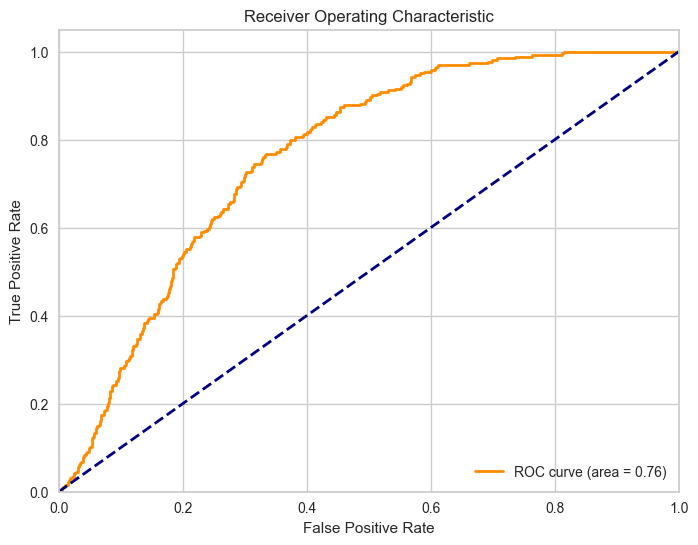

In [ ]:
evaluator.plot_roc_curve(model=best_models[best_model], X_test=X_test, y_test=y_test)

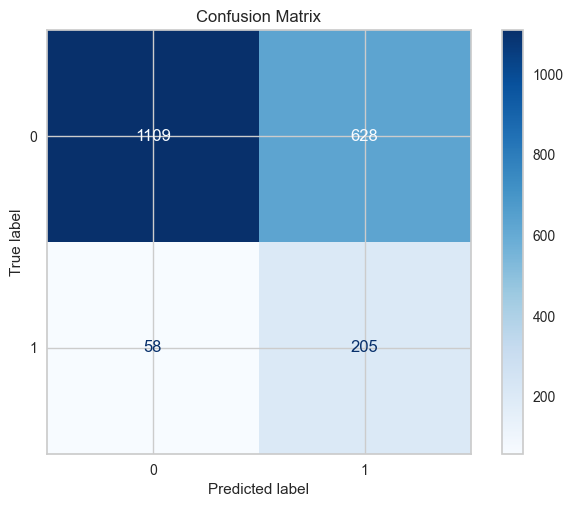

In [ ]:
evaluator.plot_confusion_matrix(
    model=best_models[best_model], X_test=X_test, y_test=y_test
)

In [ ]:
# predictions = best_models[best_model].predict(df_valid)

# output = pd.DataFrame({"index": df_valid.index, "y": predictions})

# output.head()